In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Read Data

In [2]:
def readDataRuiJinAD(filePath):
    """AD VS Normal"""
    df = pd.read_csv(filePath)
    names = df.columns[1:]
    y = df['category']
    y = np.where(y == "AD", 0, y)
    y = np.where(y == "Normal", 1, y)
    y = y.astype('int')
    X = df.iloc[:, 1:].values
    scalar = MinMaxScaler((-1, 1))
    X = scalar.fit_transform(X)
    return X, y, names, df

path2pickle = '../dataset/sample_smile_result.pkl'
X, y, names, _ = readDataRuiJinAD('../dataset/sample_alzheimer_vs_normal_data.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

Random Forest

In [3]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [4]:
cv_results  = cross_validate(rf_clf, X, y, cv=5, return_estimator=True, scoring='f1')


In [5]:
cv_results['estimator']

(RandomForestClassifier(),
 RandomForestClassifier(),
 RandomForestClassifier(),
 RandomForestClassifier(),
 RandomForestClassifier())

In [6]:
cv_results['test_score']

array([1.        , 0.95238095, 1.        , 0.88888889, 1.        ])

In [7]:
# ---- averaging --------
rf_list = []
for estimator in cv_results['estimator']:
    rf_list.append( pd.Series(rf_clf.feature_importances_, index=names).sort_values(ascending=False))

In [8]:
pd_group = pd.concat(rf_list)
group_info = pd_group.groupby(pd_group.index)
df_means = group_info.mean().sort_values(ascending=False)

In [9]:
df_means = df_means.head(20)

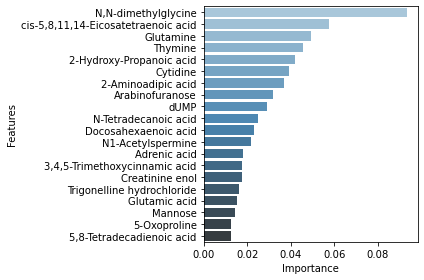

In [10]:
ax = sns.barplot(x=df_means[:20], y=df_means.index[:20], palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_rf.tif', dpi=300)
plt.show()

In [11]:
feature_scores_rf = pd.Series(rf_clf.feature_importances_, index=names).sort_values(ascending=False)

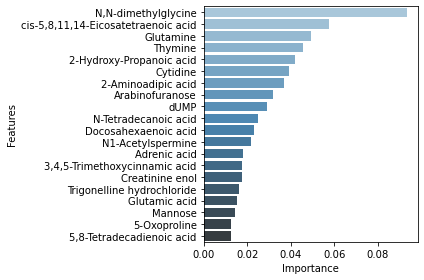

In [12]:
ax = sns.barplot(x=df_means.values, y=df_means.index,  palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_rf_avg.tif', dpi=300)
plt.show()

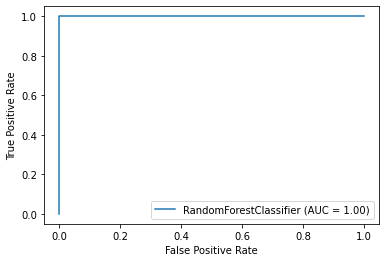

In [13]:
plot_roc_curve(rf_clf, X_test, y_test)

SVM

In [14]:
from sklearn import svm
svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(X_train,y_train)

SVC(kernel='linear')

In [15]:
cv_results  = cross_validate(svm_clf, X, y, cv=5, return_estimator=True, scoring='f1')

In [16]:
cv_results['estimator']

(SVC(kernel='linear'),
 SVC(kernel='linear'),
 SVC(kernel='linear'),
 SVC(kernel='linear'),
 SVC(kernel='linear'))

In [17]:
cv_results['test_score']

array([1.        , 1.        , 0.96      , 0.96      , 0.90909091])

In [18]:
# ---- averaging --------
svm_list = []
for estimator in cv_results['estimator']:
    svm_list.append(pd.Series(abs(estimator.coef_[0]), index=names).nlargest(20))

In [19]:
pd_group = pd.concat(svm_list)
group_info = pd_group.groupby(pd_group.index)
df_means = group_info.mean().sort_values(ascending=False)

In [20]:
df_means = df_means.head(20)

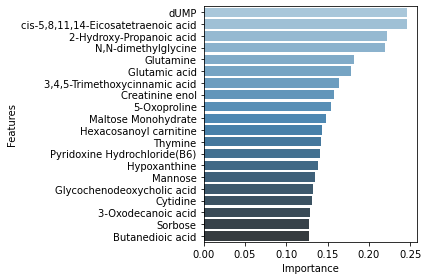

In [21]:
ax = sns.barplot(x=df_means.values, y=df_means.index, palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_svm_avg.tif', dpi=400)
plt.show()


In [22]:
y_predict = svm_clf.predict(X_test)
accuracy_score(y_predict, y_test)

0.9565217391304348

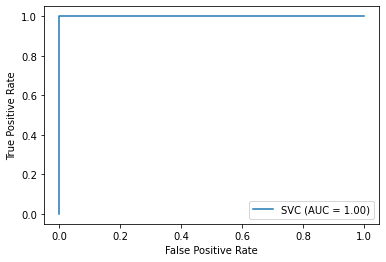

In [23]:
plot_roc_curve(svm_clf, X_test, y_test)

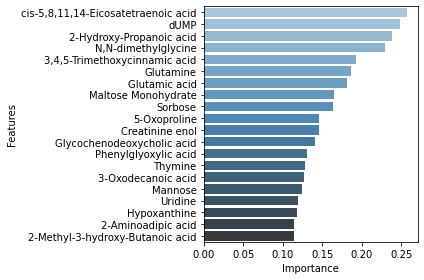

In [24]:
feature_scores_svm = pd.Series(abs(svm_clf.coef_[0]), index=names).nlargest(20)
ax = sns.barplot(x=feature_scores_svm.values, y=feature_scores_svm.index, palette="Blues_d")
ax.set(xlabel='Importance', ylabel='Features')
plt.tight_layout()
plt.savefig('f_rank_svm.tif', dpi=400)
plt.show()

